# Interpolation

Regression assumes that data are noisy and so tolerates errors in passing through datapoints.

__Interpolation__ assumes that data are exact and tries to find the best function that passes through all datapoints. Furthermore, interpolation does not require that we have already a model for the interpolating function.

# Linear interpolation

If data points $x_i$ are in ascending order and $x_i<x<x_{i+1}$, then the value of $y$ that interpolates $x$ is:
<center>$\hat{y}(x)=y_i+\dfrac{(y_{i+1}-y_i)(x-x_i)}{x_{i+1}-x_i}$</center>

This can be automated via the `scipy.interpolate` function `interp1d`.

In [34]:
from scipy.interpolate import interp1d
x=[0,0.5,1,1.5,2]
y=[10,10,20,18,10]
f=interp1d(x,y)
y_hat=f(1.5)

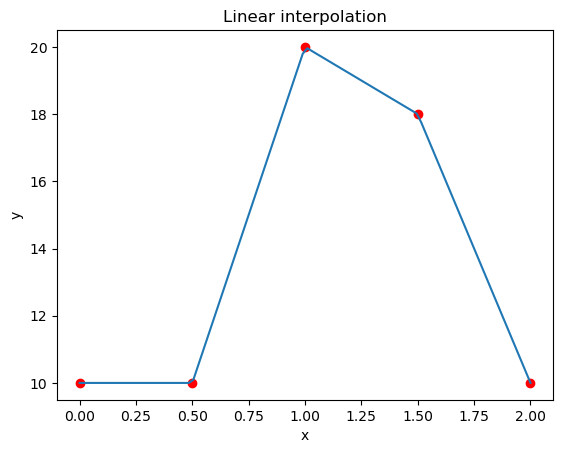

In [35]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax=plt.subplots()
xx=np.linspace(0,2,100)
ff=[f(x_i) for x_i in xx]
ax.set_title('Linear interpolation')
ax.plot(xx,ff)
ax.scatter(x,y,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# Cubic spline interpolation

Here the interpolating functions are a set of __cubic polynomials__:
we assume that $(x_i,y_i)$ and $(x_{i+1},y_{i+1})$ are connected by $S_i=a_i x^3+b_i x^2 +c_i x+d_i$.

For $n$ points there are $n-1$ cubic polynomials, each with $4$ dofs, hence we have a total of $4(n-1)$ coefficients to find.

We have immediately $2(n-1)$ constraints from the fact that each $S_i$ must intersect $y_i \,\,(y_{i+1})$ at $x_i\,\, (x_{i+1})$:
<center>$S_i(x_i)=y_i,\qquad S_{i}(x_{i+1})=y_{i+1},\qquad\forall i=1\dots n-1$</center>

Then we also require smoothness of all $S_i$ at internal interpolation points, i.e. for $i=2,\dots,n-1$ (We don't need this at the two final points $x_1$ and $x_n$). This is done by requiring that first and second derivative of consecutive $S_i$ are continuos there:
<center> $S_i'(x_{i+1})=S_{i+1}'(x_{i+1}),\qquad S_i''(x_{i+1})=S_{i+1}''(x_{i+1}),\qquad\forall i=1,\dots,n-1$</center>
This give us further $2(n-2)$ constraints.

Two more equations are needed. Usually one requires that the curve is "straight at the endpoints", i.e.:
<center>$S''_1(x_1)=0,\qquad S''_{n-1}(x_n)=0$.</center>

We can use the `scipy.interpolate` function `CubicSpline`, which lets us set the last two boundary conditions via the keyword argument `bc_type`.

In [54]:
from scipy.interpolate import CubicSpline
x = [0, 1, 2]
y = [1, 3, 2]

# use bc_type = 'natural' adds the constraints as we described above
f=CubicSpline(x, y, bc_type='natural')

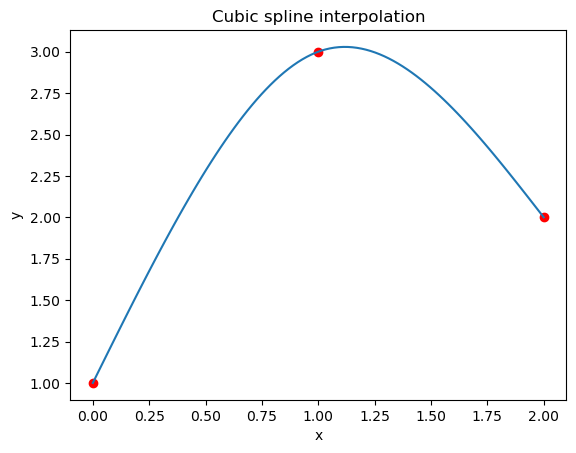

In [55]:
x_new = np.linspace(0, 2, 100)
y_new = f(x_new)
fig,ax=plt.subplots()
ax.set_title('Cubic spline interpolation')
ax.plot(x_new,y_new)
ax.scatter(x,y,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

If you want explicit coefficients for the cubic spline, you should solve the corresponding linear system explicitly, apparently.

Example: let x=[0,1,2], y=[1,3,2]. We have only two basis functions $S_1$, $S_2$ and a total of 8 coefficients to fix.
The first set of equations relate $S_1$ with $y_1, y_2$ and $S_2$ with $y_2,y_3$:

$S_1(x_1)=y_1 \rightarrow d_1=1$

$S_1(x_2)=y_2 \rightarrow a_1+b_1+c_1+d_1=3$

$S_2(x_2)=y_2 \rightarrow a_2+b_2+c_2+d_2=3$

$S_2(x_3)=y_3 \rightarrow 8 a_2+ 4 b_2+2 c_2+d_2=2$

Then we have the equations imposing smoothness of $S_1$ and $S_2$ at the junction point $x_2$:

$S_1'(x_2)=S_2'(x_2) \rightarrow 3 a_1+ 2 b_1 + c_1 = 3 a_2 +2 b_2 +c_2$

$S_1''(x_2)=S_2''(x_2) \rightarrow 6 a_1+ 2 b_1 = 6 a_2 +2 b_2$

Finally the two flatness conditions at the boundaries $x_1,x_3$:

$S_1''(x_1)=0 \rightarrow 2 b_1 = 0$

$S_2''(x_3)=0 \rightarrow 12 a_2+2 b_2 = 0$

All in all, this becomes the linear system:

$\begin{pmatrix} 0&0&0&1&0&0&0&0\\
                 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0\\
                 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1\\
                 0 & 0 & 0 & 0 & 8 & 4 & 2 & 1\\
                 3 & 2 & 1 & 0 & -3 & -2 & -1 & 0\\
                 6 & 2 & 0 & 0 &-6 & -2 & 0 & 0\\
                 0 & 2 & 0 & 0 & 0 & 0 & 0 & 0\\
                 0 & 0 & 0 & 0 & 12 & 2 & 0 &0 \end{pmatrix} $
$\begin{pmatrix}a_1 \\ b_1 \\ c_1 \\d_1 \\a_2 \\ b_2 \\ c_2 \\ d_2 \end{pmatrix}$ = $\begin{pmatrix} 1 \\ 3 \\ 3 \\ 2 \\ 0 \\ 0\\ 0 \\ 0 \end{pmatrix}$

Apparently the matrix $M$ here is always invertible if the point $x_i$ are all unique.

In [46]:
M=np.array([[0,0,0,1,0,0,0,0],[1,1,1,1,0,0,0,0],[0,0,0,0,1,1,1,1],[0,0,0,0,8,4,2,1],[3,2,1,0,-3,-2,-1,0],[6,2,0,0,-6,-2,0,0],[0,2,0,0,0,0,0,0],[0,0,0,0,12,2,0,0]])
Mm1=np.linalg.inv(M)
const=np.array([[1,3,3,2,0,0,0,0]]).T
coeffs=np.dot(Mm1,const)
print(coeffs)

[[-0.75]
 [ 0.  ]
 [ 2.75]
 [ 1.  ]
 [ 0.75]
 [-4.5 ]
 [ 7.25]
 [-0.5 ]]


In [47]:
def S1(x):
    return -0.75*x**3+2.75*x+1
def S2(x):
    return 0.75*x**3-4.5*x**2+7.25*x-0.5

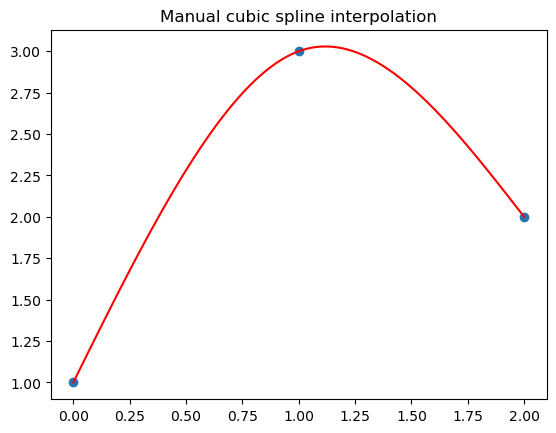

In [61]:
fig,ax=plt.subplots()
ax.set_title('Manual cubic spline interpolation')
x1_set = np.linspace(0, 1, 100)
x2_set = np.linspace(1, 2, 100)
SS1=[S1(x) for x in x1_set]
SS2=[S2(x) for x in x2_set]
ax.plot(x1_set, SS1, color='r')
ax.plot(x2_set, SS2, color = 'r')
ax.scatter([0,1,2],[1,3,2])
plt.show()

# Lagrange polynomial interpolation